# Experiment - Compare BLS model performance with historical datasets and data aggregation.
* This is an experimental idea that aggregate data points on longer time span than just one minute will improve performance and stability for any models other than RNN, especially in Fscore. 
* It is based on the thinking: An anomaly should and can only be determined by the features acrossing a rather large time span. The features extracted from the messages within only one minute are not enough to determine if there is an anomaly in this minute of time.   
* In this experiment, Aggregation of some time spans from 1 to 60 will be tested and the according mesurements (accuracy and fscore) will be compared.  
* You can specify time span and select datasets one by one, or run many tests with different parameters as a batch (integrated run) to observe the trend at the last step. 


In [1]:
# Switch between the following time spans to compare the results
time_span = 1
# time_span = 2
# time_span = 3
# time_span = 4
# time_span = 5
# time_span = 6
# time_span = 7
# time_span = 8
# time_span = 9
# time_span = 10
# time_span = 20
# time_span = 30
# time_span = 40
# time_span = 60


### Select dataset

In [2]:
import numpy as np

# Load the datasets
path_app = "src"
dataset0 = np.loadtxt("./%s/data_historical/Code_Red_I.csv" % path_app, delimiter=",")
dataset1 = np.loadtxt("./%s/data_historical/Nimda.csv" % path_app, delimiter=",")
dataset2 = np.loadtxt("./%s/data_historical/Slammer.csv" % path_app, delimiter=",")
dataset3 = np.loadtxt("./%s/data_historical/Moscow_blackout.csv" % path_app, delimiter=",")
dataset4 = np.loadtxt("./%s/data_historical/WannaCrypt.csv" % path_app, delimiter=",")
dataset5 = np.loadtxt("./%s/data_historical/RIPE_regular.csv" % path_app, delimiter=",")
dataset6 = np.loadtxt("./%s/data_historical/BCNET_regular.csv" % path_app, delimiter=",")
datasets = {"Code_Red_I": dataset0, "Nimda": dataset1, "Slammer": dataset2, "Moscow_blackout": dataset3, "WannaCrypt": dataset4, "RIPE_regular": dataset5, "BCNET_regular": dataset6}

# Select datasets
raw_train_datasets = [datasets["Code_Red_I"], datasets["Nimda"]]
raw_test_dataset = datasets["Slammer"]

# raw_train_datasets = [datasets["Nimda"], datasets["Slammer"]]
# raw_test_dataset = datasets["Code_Red_I"]

# raw_train_datasets = [datasets["Slammer"], datasets["Code_Red_I"]]
# raw_test_dataset = datasets["Nimda"]

print("Raw training datasets shape: ", [x.shape for x in raw_train_datasets])
print("Raw training labels of regular and anomaly: ", [(np.sum(x[:,-1]==-1, axis=0), np.sum(x[:,-1]==1, axis=0)) for x in raw_train_datasets])
print("Raw test dataset shape: ", raw_test_dataset.shape)
print("Raw test labels of regular and anomaly: ", np.sum(raw_test_dataset[:,-1]==-1, axis=0), np.sum(raw_test_dataset[:,-1]==1, axis=0))
# print(raw_test_dataset[3206:3220, 4:16])
# print(raw_test_dataset[3206:3220, -1])

Raw training datasets shape:  [(7200, 42), (8609, 42)]
Raw training labels of regular and anomaly:  [(6600, 600), (7308, 1301)]
Raw test dataset shape:  (7200, 42)
Raw test labels of regular and anomaly:  6331 869


### Aggregate data points
According to the feature definition, apply different aggregation function to different column.  
See src/xpr_feature_reshaping.py for explaination.

In [3]:
from src.xpr_feature_reshaping import aggregate_datasets, aggregate_rows

train_datasets = aggregate_datasets(raw_train_datasets, time_span, True)
test_dataset = aggregate_rows(raw_test_dataset, time_span, True)

print("Aggregated training datasets shape: ", [x.shape for x in train_datasets])
print("Aggregated training labels of regular and anomaly: ", [(np.sum(x[:,-1]==-1, axis=0), np.sum(x[:,-1]==1, axis=0)) for x in train_datasets])
print("Aggregated test dataset shape: ", test_dataset.shape)
print("Aggregated test labels of regular and anomaly: ", np.sum(test_dataset[:,-1]==-1, axis=0), np.sum(test_dataset[:,-1]==1, axis=0))
# print(test_dataset[1603:1613, 4:16])
# print(test_dataset[1603:1613, -1])

Aggregated training datasets shape:  [(7200, 42), (8609, 42)]
Aggregated training labels of regular and anomaly:  [(6600, 600), (7308, 1301)]
Aggregated test dataset shape:  (7200, 42)
Aggregated test labels of regular and anomaly:  6331 869


### Combine training dataset

In [4]:
def concatenate_datasets(datasets):
    result = datasets[0]
    for dataset in datasets[1:]:
        result = np.concatenate((result, dataset), axis=0)
    return result

train_dataset = concatenate_datasets(train_datasets)

print("Training dataset shape: ", train_dataset.shape)
print("Training labels of regular and anomaly: ", np.sum(train_dataset[:,-1]==-1, axis=0), np.sum(train_dataset[:,-1]==1, axis=0))
print("Test dataset shape: ", test_dataset.shape)
print("Test labels of regular and anomaly: ", np.sum(test_dataset[:,-1]==-1, axis=0), np.sum(test_dataset[:,-1]==1, axis=0))


Training dataset shape:  (15809, 42)
Training labels of regular and anomaly:  13908 1901
Test dataset shape:  (7200, 42)
Test labels of regular and anomaly:  6331 869


### Select features
Select some features instead of using all 37 features to observe how the performance changes. Default is to select all of them.

In [5]:
# Must keep the first 4 of time stamps and the last one of the label in this step.
def select_features(train_dataset, test_dataset):
    # features_to_keep=[0, 1, 2, 3, 41]
    features = [x for x in range(42)]

    train_dataset = train_dataset[:, features]
    test_dataset = test_dataset[:, features]
    return train_dataset, test_dataset

train_dataset, test_dataset = select_features(train_dataset, test_dataset)
print("Training dataset shape: ", train_dataset.shape)
print("Test dataset shape: ", test_dataset.shape)

Training dataset shape:  (15809, 42)
Test dataset shape:  (7200, 42)


### Data normalization

In [6]:
import sys
sys.path.append('./src/VFBLS_v110')
from scipy.stats import zscore
from bls.processing.replaceNan import replaceNan

def normalize(dataset, div = 1 ):
    row_index_end = dataset.shape[0] - dataset.shape[0] % div  # divisible by div, but What is div for?
    data_x = dataset[:row_index_end, 4:-1]
    data_x = zscore(data_x, axis=0, ddof=1)  # For each feature, mean = 0 and std = 1
    replaceNan(data_x)  # Replace "nan" with 0
    data_y = dataset[:row_index_end, -1]
    # Change training labels
    inds1 = np.where(data_y == -1)
    data_y[inds1] = 2
    return data_x,data_y

train_x, train_y = normalize(train_dataset)
test_x, test_y = normalize(test_dataset)

print("Training dataset shape: ", train_x.shape)
print("Training labels of regular and anomaly: ", np.sum(train_y==2), np.sum(train_y==1))
print("Test dataset shape: ", test_x.shape)
print("Test labels of regular and anomaly: ", np.sum(test_y==2), np.sum(test_y==1))


Training dataset shape:  (15809, 37)
Training labels of regular and anomaly:  13908 1901
Test dataset shape:  (7200, 37)
Test labels of regular and anomaly:  6331 869


### Select top features

In [7]:
from bls.processing.feature_select_imp_cnl import feature_select_imp_cnl

def top_features(train_x, train_y):
    # num_features = 5
    # features, _ = feature_select_imp_cnl(train_x, train_y, num_features)
    features = np.array([x for x in range(train_x.shape[1])]) # Defaut to use all features    
    return features

top = top_features(train_x, train_y)
train_x = train_x[:, top]
test_x = test_x[:, top]
print("Features: ", top+1)
print("Training dataset shape: ", train_x.shape)
print("Test dataset shape: ", test_x.shape)


Features:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
Training dataset shape:  (15809, 37)
Test dataset shape:  (7200, 37)


### Training and testing

In [8]:
from src.VFBLS_v110.bls.processing.one_hot_m import one_hot_m
from src.VFBLS_v110.bls.model.bls_train import bls_train_realtime

print("======================= BLS =======================\n")
def train_test(train_x, train_y, test_x):
    # Set parameters
    mem = 'low'
    # mem = 'high'
    # BLS parameters
    seed = 1  # set the seed for generating random numbers
    num_class = 2  # number of the classes
    epochs = 1  # number of epochs
    C = 2 ** -15  # parameter for sparse regularization
    s = 0.6  # the shrinkage parameter for enhancement nodes
    train_y = one_hot_m(train_y, num_class)
    # test_y = one_hot_m(test_y, num_class);
    #######################
    # N1* - the number of mapped feature nodes
    # N2* - the groups of mapped features
    # N3* - the number of enhancement nodes
    if mem == 'low':
        N1_bls = 20
        N2_bls = 5
        N3_bls = 100
    else:
        N1_bls = 200
        N2_bls = 10
        N3_bls = 100
    #######################

    train_err = np.zeros((1, epochs))
    train_time = np.zeros((1, epochs))
    test_time = np.zeros((1, epochs))
    np.random.seed(seed)  # set the seed for generating random numbers
    for j in range(0, epochs):
        trainingAccuracy, trainingTime, testingTime, predicted = \
        bls_train_realtime(train_x, train_y, test_x,
                            s, C,
                            N1_bls, N2_bls, N3_bls)

        train_err[0, j] = trainingAccuracy * 100
        train_time[0, j] = trainingTime
        test_time[0, j] = testingTime
    # predicted = [[1.], [2.], [2.], [2.], [2.]]
    predicted_list = []
    for label in predicted:
        predicted_list.append(label[0])
    return predicted_list

predicted_list = train_test(train_x, train_y, test_x)

print("predicted_list:", predicted_list)


======================= BLS =======================

Feature nodes in window  0 : Max Val of Output  23.818951319310674  Min Val  -26.159243918450326
Feature nodes in window  1 : Max Val of Output  21.46269039727506  Min Val  -21.01633705333135
Feature nodes in window  2 : Max Val of Output  27.88847005257514  Min Val  -27.64697081346714
Feature nodes in window  3 : Max Val of Output  28.542498283383008  Min Val  -20.94329045904536
Feature nodes in window  4 : Max Val of Output  19.723386247466042  Min Val  -22.658705022914976
Enhancement nodes: Max Val of Output  0.2834261666511703  Min Val  -1.3106946737237348
Training has been finished!
The Total Training Time is :  1.6903760433197021  seconds
xx.shape (15809, 2)
xx [[ 0.04606988  0.95392906]
 [ 0.05416705  0.94583232]
 [-0.02346581  1.02346506]
 ...
 [-0.01211854  1.01211781]
 [ 0.0638782   0.93612126]
 [-0.00466255  1.00466253]]
Training Accuracy is :  90.75210323233601  %
Testing has been finished!
The Total Testing Time is :  0.

### 6. Accuracy and Fscore

In [9]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y, predicted_list)
fscore = f1_score(test_y, predicted_list)

print(f"Accuracy: {accuracy:.2%}, Fscore: {fscore:.2%}")

Accuracy: 95.15%, Fscore: 77.95%


### 7. Integrated run


#### 7.1 Run with batch parameters

In [10]:
import os

def blockPrint():
    old_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')
    return old_stdout
def enablePrint(old_stdout):
    sys.stdout = old_stdout

time_span_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 60]
data_combos = [{"train": ["Code_Red_I", "Nimda"], "test": "Slammer"},
                {"train": ["Nimda", "Slammer"], "test": "Code_Red_I"},
                {"train": ["Code_Red_I", "Slammer"], "test": "Nimda"},]
                # {"train": ["Code_Red_I", "Nimda", "Slammer"], "test": "Moscow_blackout"},]
# all_datasets = ["Code_Red_I", "Nimda", "Slammer", "Moscow_blackout", "WannaCrypt", "RIPE_regular", "BCNET_regular"]

results = []
for combo in data_combos:
    raw_train_datasets = []
    for name in combo["train"]:
        raw_train_datasets.append(datasets[name])
    raw_test_dataset = datasets[combo["test"]]
    print(f"Data combo: {combo}")
    print("Raw training datasets shape: ", [x.shape for x in raw_train_datasets])
    print("Raw training labels of regular and anomaly: ", [(np.sum(x[:,-1]==-1, axis=0), np.sum(x[:,-1]==1, axis=0)) for x in raw_train_datasets])
    print("Raw test dataset shape: ", raw_test_dataset.shape)
    print("Raw test labels of regular and anomaly: ", np.sum(raw_test_dataset[:,-1]==-1, axis=0), np.sum(raw_test_dataset[:,-1]==1, axis=0))
    for time_span in time_span_list:
        train_datasets = aggregate_datasets(raw_train_datasets, time_span)
        test_dataset = aggregate_rows(datasets[combo["test"]], time_span)
        # train_datasets = aggregate_datasets(raw_train_datasets, time_span, True)
        # test_dataset = aggregate_rows(datasets[combo["test"]], time_span, True)
        train_dataset = concatenate_datasets(train_datasets)
        train_dataset, test_dataset = select_features(train_dataset, test_dataset)
        train_x, train_y = normalize(train_dataset)
        test_x, test_y = normalize(test_dataset)
        old_stdout = blockPrint()
        top = top_features(train_x, train_y)
        train_x = train_x[:, top]
        test_x = test_x[:, top]
        predicted_list = train_test(train_x, train_y, test_x)
        enablePrint(old_stdout)
        accuracy = accuracy_score(test_y, predicted_list)
        fscore = f1_score(test_y, predicted_list)
        row = ["+".join(combo["train"]), combo["test"], f"{time_span}", f"{accuracy*100:.2f}", f"{fscore*100:.2f}"]
        # row = ["+".join(combo["train"]), combo["test"], time_span, accuracy*100, fscore*100]
        results.append(row)
        print(f"Time span: {time_span} - Accuracy: {accuracy:.2%}, Fscore: {fscore:.2%}")

# Save the results
file_name = "src/STAT/xpr_results.csv" 
# np.savetxt("xpr_results.csv", results, delimiter=",", fmt="%s,%s,%f,%f,%f")
results.insert(0, ["Train datasets", "Test datasets", "Time span", "Accuracy %", "Fscore %"])
results = np.array(results)
np.savetxt(file_name, results, delimiter=",", fmt="%s")
print("Results saved to", file_name)

Data combo: {'train': ['Code_Red_I', 'Nimda'], 'test': 'Slammer'}
Raw training datasets shape:  [(7200, 42), (8609, 42)]
Raw training labels of regular and anomaly:  [(6600, 600), (7308, 1301)]
Raw test dataset shape:  (7200, 42)
Raw test labels of regular and anomaly:  6331 869
Time span: 1 - Accuracy: 95.15%, Fscore: 77.95%
Time span: 2 - Accuracy: 94.75%, Fscore: 75.03%
Time span: 3 - Accuracy: 95.29%, Fscore: 78.31%
Time span: 4 - Accuracy: 95.72%, Fscore: 79.90%
Time span: 5 - Accuracy: 95.97%, Fscore: 81.53%
Time span: 6 - Accuracy: 96.42%, Fscore: 84.01%
Time span: 7 - Accuracy: 96.69%, Fscore: 85.47%
Time span: 8 - Accuracy: 96.89%, Fscore: 86.14%
Time span: 9 - Accuracy: 97.00%, Fscore: 86.21%
Time span: 10 - Accuracy: 96.39%, Fscore: 83.33%
Time span: 15 - Accuracy: 96.04%, Fscore: 81.19%
Time span: 20 - Accuracy: 96.11%, Fscore: 81.58%
Time span: 25 - Accuracy: 97.92%, Fscore: 90.91%
Time span: 30 - Accuracy: 96.25%, Fscore: 83.02%
Time span: 40 - Accuracy: 95.56%, Fscore: 7

#### 7.2 Plot the result

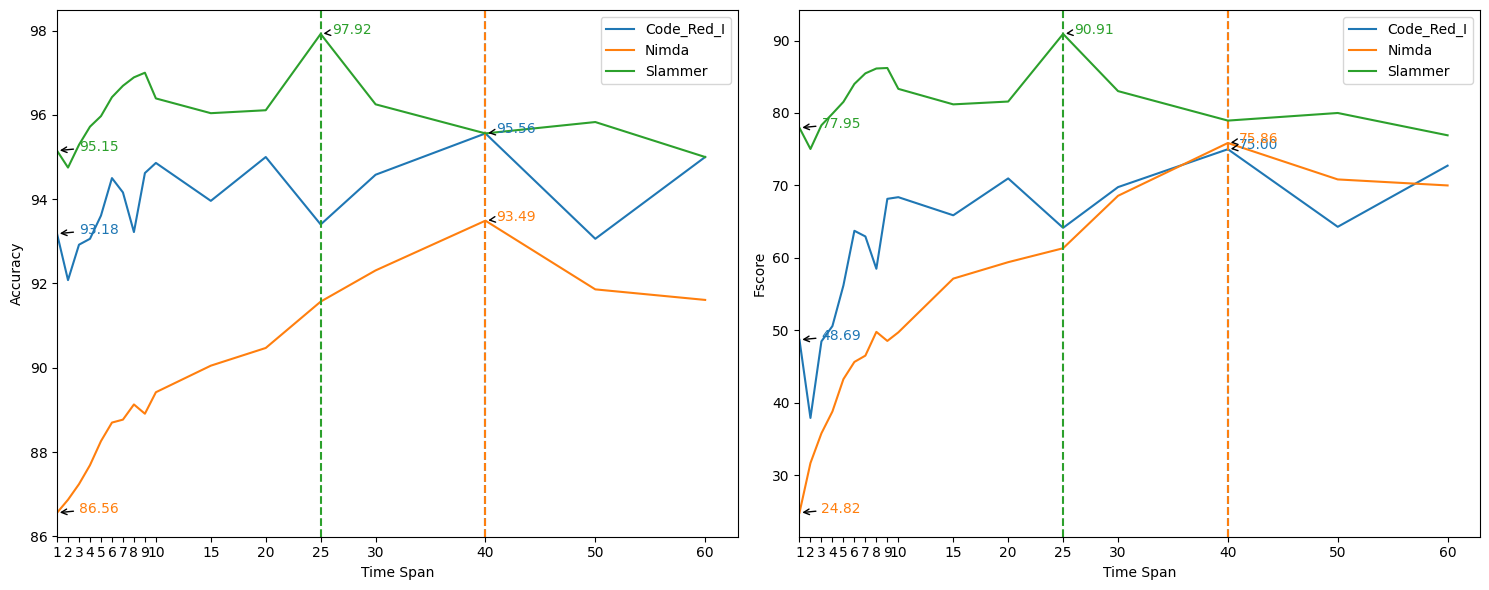

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Plot each series in a subplot
def subplot(label, series, ax, data_column):
    for series in series:
        mask = np.array([row[1] == series for row in results])
        x = results[mask, 2].astype(int)
        y = results[mask, data_column].astype(float)
        line = ax.plot(x, y, label=series)[0]
        
        # Add annotation for the point of baseline
        ax.annotate(f'{y[0]:.2f}', xy=(x[0], y[0]), xytext=(x[0] + 2, y[0]),
                    color=ax.lines[-1].get_color(), arrowprops=dict(arrowstyle='->'))
        
        # Find the index of the maximum value in y
        max_idx = np.argmax(y)
        max_x = x[max_idx]
        max_y = y[max_idx]
        
        # Draw a vertical line at the maximum value
        ax.axvline(x=max_x, color=ax.lines[-1].get_color(), linestyle='--')
        
        # Annotate the maximum value
        ax.annotate(f'{max_y:.2f}', xy=(max_x, max_y), xytext=(max_x + 1, max_y),
                    color=ax.lines[-1].get_color(), arrowprops=dict(arrowstyle='->'))
    
    ax.set_xlabel('Time Span')
    ax.set_ylabel(label)
    ax.set_xlim(left=1)
    ax.set_xticks(time_span_list)
    ax.legend()
    # fig.suptitle('Comparison of different time spans')

series = np.unique(results[1:, 1])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
subplot('Accuracy', series, ax1, 3)
subplot('Fscore', series, ax2, 4)

plt.tight_layout()
plt.show()